# Прогноз оттока клиентов

***Ссылка на папку с проектом***: https://github.com/MarNemira/portfolio_projects/tree/master/bank_clients_churn  
***Ссылка на README.MD***: https://github.com/MarNemira/portfolio_projects/blob/master/bank_clients_churn/README.md

**Тема проекта**: прогнозирование ухода клиентов из банка.  

**Цель**: построить модель, предсказывающую уход клиента из банка, со значением F1-меры не ниже 0.59.

**Поставленные задачи**:
- Исследовать баланса классов;
- Построить нескольких моделей, выбрать лучшую;
- Рассчитать значения F1-меры, измерение AUC-ROC.

**Краткий план работы:**
- Шаг 1. Загрузка файла, изучение общей информации. Составление плана по предобработке данных.
- Шаг 2. Исследование баланса классов, расчёт F1-меры, AUC-ROC.
- Шаг 3. Устранение дисбаланса классов, повторный расчёт F1-меры, AUC-ROC.
- Шаг 4. Тестирование модели, выбор наилучшей.

**Вывод**:
- Удалось достигнуть значение F1-меры не ниже 0.59;
- Среди рассматриваемых моделей лучший результат показал *случайный лес* со взвешенными классами.

**Статус проекта**: ***планируется доработка***
- В качестве альтернативы для тестирования использовать технику *GridSearchCV*;
- Для сравнения результата использовать другие модели, например, *градиентный бустинг*;
- Замерить *время выполнения* запроса, чтобы сопоставить модели по параметрам "качество - время".

**Используемые библиотеки**: *numpy*, *pandas*, *matplotlib*, *seaborn*, *re*, *scipy*, *sklearn*

**Источник данных**: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

In [1]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore') 

# импорт библиотек и функция для дальнейшей работы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# 1. Подготовка данных

Данный шаг мы разобьем на несколько этапов:  

- **1.1. Открытие файла**. Загрузка данных и изучение содержимого в общих чертах. План для дальнейшей предобработки данных.  
- **1.2. Проверка и изучение данных**. Согласно намеченному плану, проведем **предобработку** данных.
- **1.3. Подготовка данных для обучения**. Проведем **кодирование** (перевод данных в нужный тип) и **масштабирование** признаков.

## 1.1. Открытие файла

Для начала необходимо **ознакомиться** с исходными данными: **загрузим** данные и посмотрим на **общую информацию**.

In [2]:
# загрузка исходных данных
data_raw = pd.read_csv('/datasets/Churn.csv')
data_raw.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
# вывод общей информации
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
# доля оставшихся - 0 и ушедших - 1 клиентов
data_raw['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

В данных содержится **10000 строк** и **14 столбцов**.  
Ниже содержится **описание** каждого столбца и отмечены моменты, на которые нужно обратить внимание:

**ПРИЗНАКИ**
- **RowNumber** - индекс строки в данных.  
По сути, этот столбец совпадает с **индексами** датафрейма. При обучении он не нужен, иначе модель будет рассматривать это как значимый признак и включать его в расчёты.


- **CustomerId** - уникальный идентификатор клиента.  
Необходимо проверить, чтобы в датафрейме не было **задублированных id**. Но данный столбец тоже не понадобится для обучения.


- **Surname** - фамилия.  
Смущает, что в строке с индексом 9 фамилия записана как **H?**. Либо это ошибка, либо это не прочитался знак.  
На работу модели это не повлияет, но в целом выглядит не совсем корректно.


- **CreditScore** - кредитный рейтинг.  
Можно посмотреть на распределение кредитного рейтинга и взаимосвязь с другими показателями.


- **Geography** - страна проживания.  
Посмотрим, в каких странах работает наш банк.


- **Gender** - пол.  
Проверим, чтобы в данных было только два значения Female и Male.


- **Age** - возраст.  
Проверим, чтобы возраст был в рамках разумного (не ниже 18 и не больше, например, 90).


- **Tenure** - количество недвижимости у клиента.  
В столбце есть пропуски. Но, возможно, это означает, что у клиента **нет недвижимости**. Проверим это.


- **Balance** - баланс на счёте.  
Пропусков нет, можно проверить взаимосвязь с другими переменными. Судя по странам, скорее всего, речь идёт о **евро**. Но поскольку валюта в задании не указана, будем использовать название **"условная единица (у. е.)"**.


- **NumOfProducts** - количество продуктов банка, используемых клиентом.  
Можно определить, сколько продуктов в среднем приходится на клиента.


- **HasCrCard** - наличие кредитной карты.  
Проверим, чтобы имелось только два значения: 0 и 1.


- **IsActiveMember** - активность клиента.  
В описании сказано, что это **субъективный** показатель, введенный для показательности идеи: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling. Аналогично, проверим на отсутствие другие значений, кроме 0 и 1.


- **EstimatedSalary** - предполагаемая зарплата.
Также можно посмотреть на распределение и взаимосвязь с другими переменными.


**ЦЕЛЕВОЙ ПРИЗНАК**
- **Exited** - факт ухода клиента.  
Через value_counts() мы уже проверили, что в данных есть только значения 0 и 1. В выборке **ушедшими** является **20% клиентов**.

## 1.1. Вывод

- Были **загружены** исходные данные и изучена **общая информация**.
- В данных содержится **10000 строк и 14 столбцов**. 
- **Целевой признак** - колонка **Exited** (клиент ушёл - 1, не ушёл - 0). В выборке **ушедшими** является **20% клиентов**, т. е. наблюдается **дисбаланс** классов.
- Присутствуют как **категориальные**, так и **количественные** переменные. В последующих шагах необходимо решить вопрос с **кодированием**.
- В колонке **Tenure** (количество недвижимости у клиента) есть **пропуски**.

## 1.2. Проверка и изучение данных

#### 1. RowNumber

Поскольку данный столбец не понадобится для обучения модели, **удалим** его из рабочего датафрейма.

In [5]:
# удаление столбца RowNumber
data = data_raw.drop('RowNumber', axis=1)
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### 2. CustomerId

Проверим столбец на наличие **дубликатов**:

In [6]:
# подсчет количества дубликатов
data['CustomerId'].duplicated().sum()

0

Дубликатов в id нет, всё в порядке. Однако для **обучения** модели этот столбец **не потребуется**: при обучении уникальный id не покажет каких-либо закономерностей, но будет восприниматься как цифра.

In [7]:
# удаление столбца CustomerId
data.drop('CustomerId', axis=1, inplace=True)
data.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### 3. Surname

Обычно фамилия начинается с **заглавной буквы**, после которой идут **строчные буквы**. Ранее мы уже столкнулись с подозрительной фамилией **H?**. Проверим фамилии по выше указанному стандартному образцу и посмотрим, есть ли ещё "подозрительные" фамилии:

In [8]:
# образец - заглавная латинская, далее строчные
pattern = '^[A-Z]\w*$'

# применеие регулярного выражения
mask = data['Surname'].str.contains(pattern)

# вывод фамилий, которые отличаются от стандартного образца
mask_invert = ~mask
invalid_names = data.loc[mask_invert]
invalid_names_list = invalid_names['Surname'].unique()
invalid_names_list

array(['H?', "O'Brien", "T'ien", "T'ang", "T'ao", "Ch'ien", "O'Sullivan",
       "Ch'iu", "K'ung", "O'Donnell", "Ts'ai", 'L?', 'De Salis', 'Hs?',
       "Ch'en", 'De Luca', 'Wentworth-Shields', "Ts'ao", "Ch'ang", "P'an",
       "Ts'ui", "P'eng", "Ch'eng", "O'Loghlen", 'Y?an', "Ch'in",
       'Li Fonti', 'Winter-Irving', "O'Neill", 'Drake-Brockman', "T'an",
       'K?', "D'Albertis", 'Le Grand', 'Y?', "O'Meara", "O'Toole",
       'Lo Duca', 'Collingridge de Tourcey', 'Le Gallienne',
       'De Bernales', "O'Connor", 'Warlow-Davies', 'De Garis', 'Hs?eh',
       'Du Cane', 'De Neeve', 'To Rot', 'Hughes-Jones', 'Cumbrae-Stewart',
       'Radcliffe-Brown', 'Edmund la Touche', 'Parry-Okeden',
       "O'Loughlin", 'Ross-Watt', 'Fleetwood-Smith', 'Barclay-Harvey',
       'Le Hunte', "O'Loghlin", "O'Callaghan", 'Ah Mouy', 'Howell-Price',
       'St Clair', 'Von Doussa', 'De Mestre', 'Marshall-Hall',
       'Hayes-Williams', "O'Kane"], dtype=object)

Какие-то фамилии имеют **другие знаки** (например, ирландские фамилии типа "O'Connor") либо **пробелы** (например, "De Neeve") - это нормально, такое может быть. Однако, встречаются и фамилии с **"?"**, как в случае с "H?".  

Выведем список фамилий с **вопросительными знаками**:

In [9]:
# проверяем фамилии в списке
for word in invalid_names_list:
    
    # образец: в слове есть ?
    pattern = '^\w*\?\w*$'
    
    # если слово соответствует образцу - печатаем
    if bool(re.match(pattern = pattern, string = word)):
            print(word)

H?
L?
Hs?
Y?an
K?
Y?
Hs?eh


Для **текущей задачи** некорректно написанные фамилии **не так важны**. Но в реальной жизни об этой проблеме можно было бы сообщить коллегам, ответственным за выгрузку.

Посмотрим, сколько всего уникальных фамилий в датасете:

In [10]:
# количество уникальных фамилий
print('Количество уникальных фамилий:', data['Surname'].nunique())

Количество уникальных фамилий: 2932


В данных **много однофамильцев**. Безусловно, есть вероятность нахождения закономерности в фамилиях (например, Ивановы чаще уходят из банка, чем Сидоровы). Однако мы **не будем кодировать** фамилии для машинного обучения, т. к. кажется, что это излишним. Удалим этот столбец из рабочего датафрейма:

In [11]:
# удаление столбца Surname
data.drop('Surname', axis=1, inplace=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### 4. CreditScore

Посмотрим на сводную статистику **кредитного рейтинга** по целевому признаку (выбыл клиент или нет).

Напишем функцию, которая будет выводить <b>сводную статистику</b> и <b>строить боксплоты</b> для данных, в которых нужно изучить распределение:

In [12]:
def sumstat_and_boxplot(df_name, col_name, group_by, box_title, box_ylabel, box_yticks=None):
    
    """Функция возвращает боксплот и сводную статистику по колонке с учётом разбивки по группам.
    - df_name - название датафрейма
    - col_name - рассматриваемая колонка
    - group_by - колонка, по которой происходит разбивка по группам
    - box_title - указать в именительном падеже название колонки
    - box_ylabel - указать название оси y
    - box_yticks (необязательный параметр) - задать диапазон для оси y"""
    
    boxplot = df_name.boxplot(col_name, by=group_by, figsize=(7, 5))
    plt.title('Сравнение по ушедшим и действующим клиентам (' + box_title + ')')
    plt.xlabel('Тип клиента (0 - действующий, 1 - ушедший)')
    plt.ylabel(box_ylabel)
    plt.yticks(box_yticks)
    plt.show()
    
    sumstat = df_name.groupby(group_by)[col_name].describe()
    return sumstat

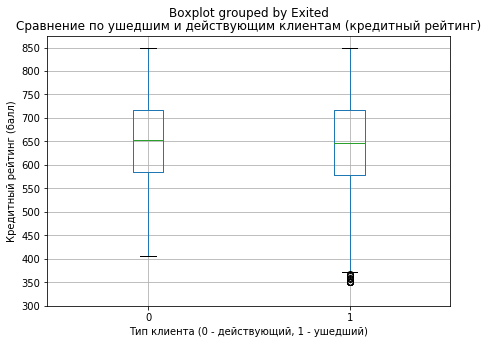

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7963.0,651.853196,95.653837,405.0,585.0,653.0,718.0,850.0
1,2037.0,645.351497,100.321503,350.0,578.0,646.0,716.0,850.0


In [13]:
# применение функции для CreditScore
sumstat_and_boxplot(data, 'CreditScore', 'Exited', 'кредитный рейтинг', 'Кредитный рейтинг (балл)', [i*50 for i in range(6, 18)])

**Размах, среднее и медиана** для обоих типов клиентов (ушедшие и действующие клиенты) очень **похожи**.  
Для обоих случаев **максимум - 850 баллов**. Возможно, 850 баллов в принципе является **максимумом** по этой шкале.

Посмотрим на распределение данных на **гистограмме**:

Напишем функцию, которая будет выводить <b>две гистограммы</b> по колонке с учётом разбивки <b>по группам</b>:

In [14]:
def hist_by_groups(df_name, col_name, group_by, box_title, box_xlabel, box_xticks=None, n_bins=30):
    
    """Функция возвращает две гистограммы по колонке с учётом разбивки по группам.
    - df_name - название датафрейма
    - col_name - рассматриваемая колонка
    - group_by - колонка, по которой происходит разбивка по группам
    - box_title - указать в именительном падеже название колонки
    - box_xlabel - указать название оси x
    - box_xticks (необязательный параметр) - задать диапазон для оси x
    - n_bins - количество корзин для гистограмм"""
    
    # настройка размера
    plt.figure(figsize=(9,5))
    
    # построение гистограммы
    # на одном графике построим распределение данных
    sns.distplot(df_name[df_name[group_by] == 1][col_name], kde=True, label='ушедший', bins=n_bins)
    sns.distplot(df_name[df_name[group_by] == 0][col_name], kde=True, label='действующий', bins=n_bins)

    # линии среднего значения
    plt.axvline(x=df_name[df_name[group_by] == 1][col_name].mean(), color='blue', linestyle='--', label='ушедший (среднее)')
    plt.axvline(x=df_name[df_name[group_by] == 0][col_name].mean(), color='orange', linestyle='--', label='действующий (среднее)')

    plt.title('Распределение по ушедшим и действующим клиентам (' + box_title + ')')
    plt.xlabel(box_xlabel)
    plt.xticks(box_xticks, rotation=45)

    plt.legend()
    plt.grid()
    plt.show()

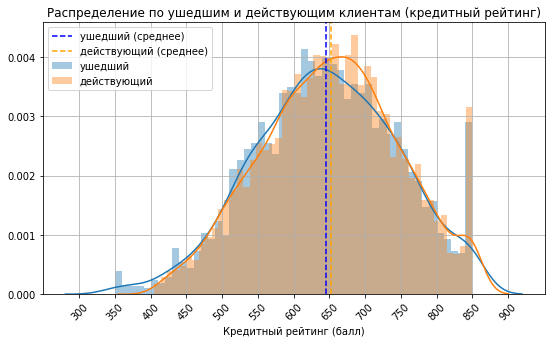

In [15]:
# применение функции для CreditScore
hist_by_groups(data, 'CreditScore', 'Exited', 'кредитный рейтинг', 'Кредитный рейтинг (балл)', [i*50 for i in range(6, 19)], 50)

**Распределение** выборочных данных по клиентам **похоже на нормальное**: симметричность, выраженный пик в районе среднего.  
Наблюдается **обрыв справа** и **пик** в районе **максимального рейтинга 850**. Как мы заметили ранее, возможно, 850 баллов и есть предел по шкале, поэтому выше 850 баллов оценок не существует - в результате этого мы видим пик и обрыв.

Таким образом, кредитный рейтинг в целом можно описать **нормальным распределением**. Также при этом можно отметить, что в обоих случаях наблюдается пик в районе 850 баллов, что говорит о доле клиентов с **высоким рейтингом**.

#### 5. Geography

Посмотрим, по каким **странам** собраны данные и какая картина по ушедшим клиентам:

In [16]:
# доля по странам
print(data['Geography'].value_counts(normalize=True))
print()

# группировка по странам
pivot_check = data.pivot_table(index='Geography', columns='Exited', aggfunc='count')['Age']

# вывод доли ушедших
print('Доля ушедших (Франция): {:.2%}'.format(pivot_check.iloc[0, 1] / pivot_check.iloc[0].sum()))
print('Доля ушедших (Германия): {:.2%}'.format(pivot_check.iloc[1, 1] / pivot_check.iloc[1].sum()))
print('Доля ушедших (Испания): {:.2%}'.format(pivot_check.iloc[2, 1] / pivot_check.iloc[2].sum()))

pivot_check

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

Доля ушедших (Франция): 16.15%
Доля ушедших (Германия): 32.44%
Доля ушедших (Испания): 16.67%


Exited,0,1
Geography,,
France,4204,810
Germany,1695,814
Spain,2064,413


В датасете **50% строк** приходятся на клиентов из **Франции**, и примерно **по 25%** на клиентов из **Германии** и **Испании**.  
В выборке **самый большой отток** клиентов наблюдается в **Германии** - ушло около **32% от общего числа** выборочных клиентов. В остальных странах этот показатель на уровне **16%**.

#### 6. Gender

Посмотрим, какие значения **пола** присутствуют в выборке:

In [17]:
# доля по полу
print(data['Gender'].value_counts(normalize=True))
print()

# группировка по полу
pivot_check = data.pivot_table(index='Gender', columns='Exited', aggfunc='count')['Age']

# вывод доли ушедших
print('Доля ушедших (женщины): {:.2%}'.format(pivot_check.iloc[0, 1] / pivot_check.iloc[0].sum()))
print('Доля ушедших (мужчины): {:.2%}'.format(pivot_check.iloc[1, 1] / pivot_check.iloc[1].sum()))

pivot_check

Male      0.5457
Female    0.4543
Name: Gender, dtype: float64

Доля ушедших (женщины): 25.07%
Доля ушедших (мужчины): 16.46%


Exited,0,1
Gender,,
Female,3404,1139
Male,4559,898


В выборке присутствует всего **два значения пола**: **мужчин (55%)** немного больше, чем **женщин (45%)**.  
По выборочным данным **ушло 16%** от общего числа **мужчин** и **25%** от общего числа **женщин**.

#### 7. Age

Посмотрим на сводную статистику для **возраста** по целевому признаку (выбыл клиент или нет) и заодно проверим, значения на **адекватность** (не ниже 18 лет и не старше 90 лет):

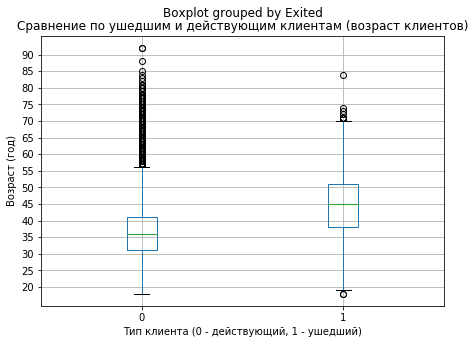

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7963.0,37.408389,10.125363,18.0,31.0,36.0,41.0,92.0
1,2037.0,44.837997,9.761562,18.0,38.0,45.0,51.0,84.0


In [18]:
# применение функции для Age
sumstat_and_boxplot(data, 'Age', 'Exited', 'возраст клиентов', 'Возраст (год)', [i*5 for i in range(4, 19)])

По выборочным данным для **действующих** клиентов **среднее и медиана** в районе **36-37 лет**.  
По **ушедшим** клиентам выборочное среднее и медиана несколько **выше**: в районе **45 лет**.

Для обоих случаев **минимальный возраст** - это **18 лет**, т. е. значение адекватное. **Максимальный возраст** в выборке - **92 года**. Несколько больше, чем мы предполагали изначально. Но допустить, что клиентом банка может быть человек 92 лет вполне возможно.

Посмотрим на распределение данных на **гистограмме**:

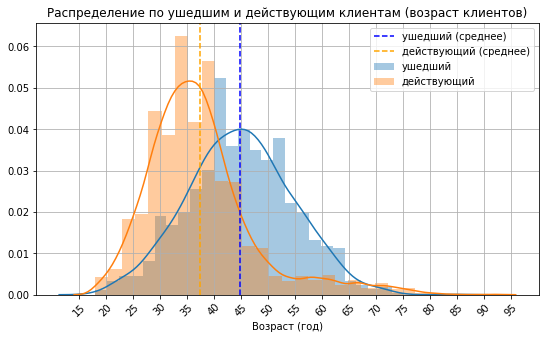

In [19]:
# применение функции для Age
hist_by_groups(data, 'Age', 'Exited', 'возраст клиентов', 'Возраст (год)', [i*5 for i in range(3, 20)], 30)

Распределение выборочных данных также похоже на **нормальное**. Однако, как было отмечено выше, распределения выборочных данных несколько **различаются**, что отражается, например, на таких показателях, как **среднее** и **медиана**.  

На первый взгляд кажется, что **действующие клиенты банка более молодые**, чем ушедшие.  
Ради интереса проверим гипотезу:
- **Нулевая гипотеза H0:** в среднем возрасте ушедших и действующих клиентов банка **разницы нет**, т. е. **возраст одинаковый**.
- **Альтернативная гипотеза H1:** в среднем возрасте ушедших и действующих клиентов банка **есть разница**, т. е. **возраст не одинаковый**.

In [20]:
# выборочные срезы
sample_exit = data.query('Exited == 1')['Age']
sample_active = data.query('Exited == 0')['Age']

# установка порога p-уровня значимости
alpha = .05

# применение теста
results = st.ttest_ind(sample_exit, sample_active, equal_var = False)

# вывод результатов
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.7127272656641046e-179
Отвергаем нулевую гипотезу


У нас **получилось** отвергнуть нулевую гипотезу, значит, есть основания полагать, что возраст ушедших и активных клиентов всё-таки **различается**.

Итак, мы проверили, что **возраст** клиентов в датасете находится в пределах разумного - **от 18 до 92 лет**.  
**Распределение** данных **похоже на нормальное**. При этом наблюдаются **различия** в среднем возрасте **ушедших** и **действующих** клиентов.  

#### 8. Tenure

Как мы помним, в данной колонке были **пропуски**. Изначально мы предположили, что **пропуск** - это **отсутствие** недвижимости у клиента.  
Посмотрим, какие значения по количеству недвижимости есть в датасете:

In [21]:
data['Tenure'].value_counts(dropna=False)

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Видим, что в данных есть **нулевые значения**. Значит, **пропуск** может означать не только 0, но и в принципе **отсутствие информации**.  
В данных **около 9% строк** имеют **пропуск** по колонке Tenure.

In [22]:
# вывод среза с пропусками
data.query('Tenure.isnull()').head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Для корректного обучения модели в признаках **не должно быть пропусков**. Примем решение **удалить строки с пропусками**.  

Но вдруг, в данные с пропусками по Tenure попало **очень много** строк с **целевым признаком**?  
Или же **непропорционально большая доля** какой-либо категории, например, клиенты с очень высокой зарплатой или жители Германии?

Предварительно нужно убедиться, что пропуски распределены более-менее равномерно. Проверим, что мы **не выбросим непропорционально много** данных какой-либо категории. 

In [23]:
# проверка целевой переменной
print('Значения с пропусками:')
print(data.query('Tenure.isnull()')['Exited'].value_counts(normalize=True))
print()
print('Значения без пропусков:')
print(data.query('Tenure.notnull()')['Exited'].value_counts(normalize=True))

Значения с пропусками:
0    0.79868
1    0.20132
Name: Exited, dtype: float64

Значения без пропусков:
0    0.796062
1    0.203938
Name: Exited, dtype: float64


In [24]:
# проверка географических значений
print('Значения с пропусками:')
print(data.query('Tenure.isnull()')['Geography'].value_counts(normalize=True))
print()
print('Значения без пропусков:')
print(data.query('Tenure.notnull()')['Geography'].value_counts(normalize=True))

Значения с пропусками:
France     0.510451
Spain      0.251925
Germany    0.237624
Name: Geography, dtype: float64

Значения без пропусков:
France     0.500495
Germany    0.252227
Spain      0.247278
Name: Geography, dtype: float64


In [25]:
# проверка пола
print('Значения с пропусками:')
print(data.query('Tenure.isnull()')['Gender'].value_counts(normalize=True))
print()
print('Значения без пропусков:')
print(data.query('Tenure.notnull()')['Gender'].value_counts(normalize=True))

Значения с пропусками:
Male      0.531353
Female    0.468647
Name: Gender, dtype: float64

Значения без пропусков:
Male      0.547135
Female    0.452865
Name: Gender, dtype: float64


В выборках **без** и **с пропусками** примерно **одинаковая доля** по **целевому признаку** (остался - ушёл), а также по **странам** и по **полу*.

In [26]:
# проверка количественных признаков С пропусками
data.query('Tenure.isnull()').describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


In [27]:
# проверка количественных признаков БЕЗ пропусков
data.query('Tenure.notnull()').describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938
std,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000
50%,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000
75%,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


Данные по **количественным признакам** тоже достаточно похожи.

Итак, проверив срезы с пропусками и без, теперь можем удалить **строки с пропусками**:

In [28]:
print('Количество строк исходного датафрейма:', len(data))
data_drop = data.query('Tenure.notnull()')
print('Количество строк после удаления пропусков:', len(data_drop))

Количество строк исходного датафрейма: 10000
Количество строк после удаления пропусков: 9091


#### 9. Balance

Рассмотрим информацию по **балансу на счете**.

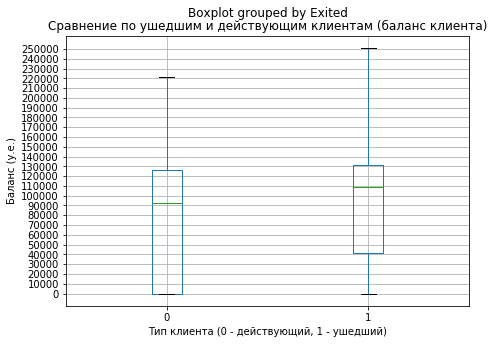

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7237.0,72824.969322,62836.651158,0.0,0.0000,92347.960,126428.380,221532.80
1,1854.0,90956.810410,58114.883718,0.0,41644.2675,109057.435,131037.045,250898.09


In [29]:
# применение функции для Balance
sumstat_and_boxplot(data_drop, 'Balance', 'Exited', 'баланс клиента', 'Баланс (у.е.)', [i*10000 for i in range(26)])

Cамое **максимальное** значение по выборке (250898.09 у. е.) наблюдается у клиента, который в итоге **ушёл** из банка.  
Клиенты с **нулевым балансом** есть среди и ушедших, и действующих. При этом среди **действующих** наблюдается **более широкий размах**, который тяготеет в меньшую сторону: граница **первой квартили** располагается на отметке 0, т. е. в 25% строк **нулевой баланс**. 

Выведем количество строк, где **баланс равен нулю**:

In [30]:
print('Количество строк с нулевым балансом:', len(data_drop.query('Balance == 0')))
print('Ушедшие клиенты с нулевым балансом:', len(data_drop.query('Balance == 0 and Exited == 1')))

Количество строк с нулевым балансом: 3283
Ушедшие клиенты с нулевым балансом: 452


**Больше трети строк** из оставшихся имеют значение **баланса 0**. При этом **только 14%** из них приходится на **ушедших** клиентов. Значит, среди **действующих** клиентов много клиентов с **нулевым балансом**.

Посмотрим на распределение данных на **гистограмме**:

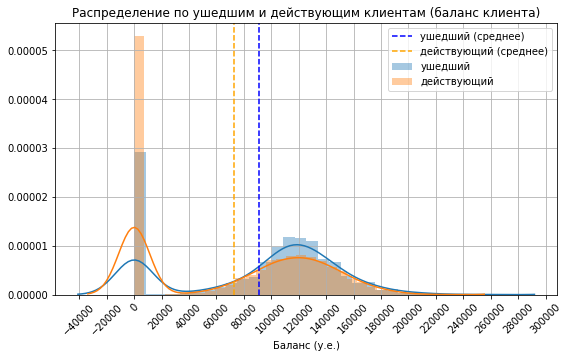

In [31]:
# применение функции для Balance
hist_by_groups(data_drop, 'Balance', 'Exited', 'баланс клиента', 'Баланс (у.е.)', [i*20000 for i in range(-2, 16)], 30)

Видим, что на распределение очень сильно влияют **нулевые** значения баланса: наблюдается аномально большой **пик около 0** как для ушедших, так и для действующих клиентов. Посмотрим на гистограммы **без нулевых значений**:

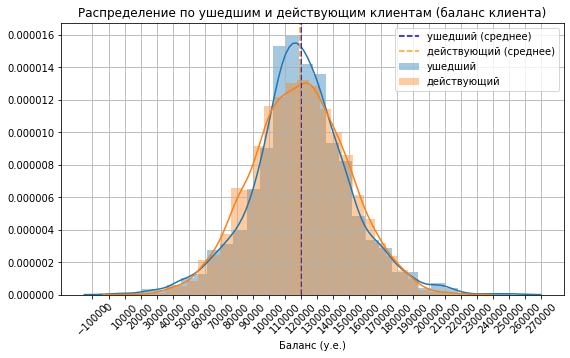

In [32]:
# срез для баланса больше 0
data_drop_balance = data_drop.query('Balance > 0')
# применение функции для Balance
hist_by_groups(data_drop_balance, 'Balance', 'Exited', 'баланс клиента', 'Баланс (у.е.)', [i*10000 for i in range(-1, 28)], 30)

**Без учета нулевого пика**, данные для обоих случаев достаточно **похожи** и хорошо согласуются с **нормальным распределением**: симметричность, унимодальность, пик в районе среднего.

Таким образом, в выброчных данных **треть клиентов** имеет **нулевой баланс** на счёте. Причем большая часть строк **нулевого баланса** приходится не на ушедших, а на **действующих** клиентов. Если **не учитывать** нулевой баланс, то распределение данных по ушедшим и действующим клиентам визуально похоже на **нормальное** с пиком в районе **среднего значения (около 120 тысяч у. е.)**.

В реальной жизни стоило бы дополнительно рассмотреть вопрос, почему в выборке так много **клиентов с нулевым балансом**, особенно среди **действующих**.

#### 10. NumOfProducts

Посмотрим, какие есть значения в переменной NumOfProducts (количество продуктов банка, используемых клиентом).

In [33]:
# доля по количеству продуктов
print(data_drop['NumOfProducts'].value_counts(normalize=True))
print()

# группировка по количеству продуктов
pivot_check = data_drop.pivot_table(index='NumOfProducts', columns='Exited', aggfunc='count')['Age']

# вывод доли ушедших
print('Доля ушедших (1 продукт): {:.2%}'.format(pivot_check.iloc[0, 1] / pivot_check.iloc[0].sum()))
print('Доля ушедших (2 продукта): {:.2%}'.format(pivot_check.iloc[1, 1] / pivot_check.iloc[1].sum()))
print('Доля ушедших (3 продукта): {:.2%}'.format(pivot_check.iloc[2, 1] / pivot_check.iloc[2].sum()))
print('Доля ушедших (4 продукта): {:.2%}'.format(pivot_check.iloc[3, 1] / pivot_check.iloc[3].sum()))

pivot_check

1    0.507865
2    0.460235
3    0.025740
4    0.006160
Name: NumOfProducts, dtype: float64

Доля ушедших (1 продукт): 27.79%
Доля ушедших (2 продукта): 7.70%
Доля ушедших (3 продукта): 82.48%
Доля ушедших (4 продукта): 100.00%


Exited,0,1
NumOfProducts,,
1,3334.0,1283.0
2,3862.0,322.0
3,41.0,193.0
4,NaN,56.0


В выборке подавляющее **большинство** клиентов пользуется **либо 1, либо 2 продуктами банка** (более 90% клиентов выборки).

Любопытно, что **максимальное количество продуктов** в выборке равно **4**, причем все случаи приходятся на клиентов **ушедших из банка**. Также высока доля **ушедших** клиентов среди тех, кто пользуется **3 продуктами банка**.  
Люди остались недовольны сервисом? Воспользовались краткосрочными выгодными программами, затем ушли из банка? Или это вообще мошенничество? Такая закономерность вызывает вопросы.

#### 11. HasCrCard

Переменная **HasCrCard** говорит о наличии либо отсутствии **кредитной карты**.

In [34]:
# доля по наличию кредитной карты
print(data_drop['HasCrCard'].value_counts(normalize=True))
print()

# группировка по наличию кредитной карты
pivot_check = data_drop.pivot_table(index='HasCrCard', columns='Exited', aggfunc='count')['Age']

# вывод доли ушедших
print('Доля ушедших (у кого нет кредитной карты): {:.2%}'.format(pivot_check.iloc[0, 1] / pivot_check.iloc[0].sum()))
print('Доля ушедших (у кого есть кредитная карта): {:.2%}'.format(pivot_check.iloc[1, 1] / pivot_check.iloc[1].sum()))

pivot_check

1    0.704983
0    0.295017
Name: HasCrCard, dtype: float64

Доля ушедших (у кого нет кредитной карты): 20.73%
Доля ушедших (у кого есть кредитная карта): 20.25%


Exited,0,1
HasCrCard,,
0,2126,556
1,5111,1298


В выборке больше клиентов, у которых **есть кредитная карта** (около **70%** клиентов). При этом доля **ушедших** среди тех, у кого есть и нет кредитной карты, довольно одинаковая - **порядка 20%**.

#### 12. IsActiveMember

В задании сказано, что **IsActiveMember** (активность клиента) - это **субъективный** показатель, который оценивает, можно ли клиента назвать условно активным.

In [35]:
# доля по наличию кредитной карты
print(data_drop['IsActiveMember'].value_counts(normalize=True))
print()

# группировка по полу
pivot_check = data_drop.pivot_table(index='IsActiveMember', columns='Exited', aggfunc='count')['Age']

# вывод доли ушедших
print('Доля ушедших (неактивный клиент): {:.2%}'.format(pivot_check.iloc[0, 1] / pivot_check.iloc[0].sum()))
print('Доля ушедших (активный клиент): {:.2%}'.format(pivot_check.iloc[1, 1] / pivot_check.iloc[1].sum()))

pivot_check

1    0.515565
0    0.484435
Name: IsActiveMember, dtype: float64

Доля ушедших (неактивный клиент): 26.84%
Доля ушедших (активный клиент): 14.34%


Exited,0,1
IsActiveMember,,
0,3222,1182
1,4015,672


В целом в выборке доля так называемых **активных** и **не активных** клиентов практически одинаковая.  
Однако доля **ушедших** среди **активных** клиентов почти в **2 раза ниже**, чем среди **неактивных**. 

#### 13. EstimatedSalary

Рассмотрим информацию по **предполагаемой зарплате**.

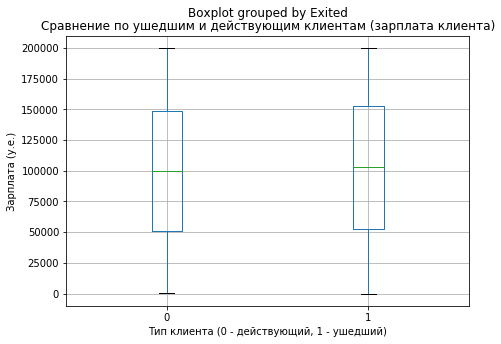

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7237.0,99713.716131,57517.666951,90.07,50839.85,99490.010,148727.42,199992.48
1,1854.0,102006.074018,58020.424361,11.58,52539.81,103210.755,152906.07,199808.10


In [36]:
# применение функции для EstimatedSalary
sumstat_and_boxplot(data_drop, 'EstimatedSalary', 'Exited', 'зарплата клиента', 'Зарплата (у.е.)')

В целом распределения и выборочные значения **среднего** и **медианы** для обоих случаев достаточно похожи (в район **100 тысяч у. е.**).

Cамые **максимальные** значение по выборке также похожи для обоих типов клиентов (около **200 тысяч у. е.**).  
В данных **отсутствуют** клиенты с **нулевой зарплатой**. При этому **минимум** для **ушедших** клиентов ниже, чем для **действующих** (12 у. е. и 90 у. е. соответственно).

Посмотрим на распределение данных на **гистограмме**:

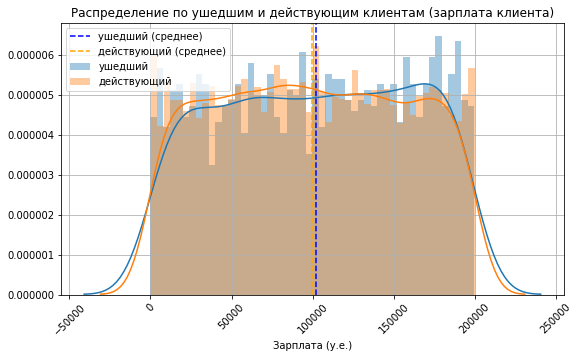

In [37]:
# применение функции для EstimatedSalary
hist_by_groups(data_drop, 'EstimatedSalary', 'Exited', 'зарплата клиента', 'Зарплата (у.е.)', None, 50)

Распределение данных **не нормальное**. Приблизительно с **одинаковой частотой** можно встретить людей как с **высокой** зарплатой **около 200 тысяч**, так и людей со **средней (100 тысяч)** и **низкой** зарплатой (близко расположенной к нулю).  
В распределении **нет ярко выраженного пика**: можно сказать, что одна **половина** клиентов получает зарплату **до 100 тысяч у. е.**, а вторая - **больше 100 тысяч**. Но в среднем все получают зарплату 100 тысяч. 

#### 14. Матрица корреляций

Дополнительно посмотрим на **взаимосвязь между переменными**. Возможно, мы сможем обнаружить какую-нибудь интересную закономерность.

Для начала посмотрим на взаимосвязи для **действующих** (т. е. не ушедших) клиентов банка.  

Построим **матрицу корреляции**, **карту интенсивности** корреляции - переменных много, так будет проще сразу найти выдающиеся значения, и **график с корреляциями scatter_matrix** для визуализации корреляций.

In [38]:
# дейсвующие клиенты
# матрица с корреляциями
not_exited_matrix = data_drop.query('Exited == 0').drop(['Exited'], axis=1)
not_exited_matrix.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.000000,0.005921,-0.008127,0.005806,0.013502,-0.005405,0.035510,0.017377
Age,0.005921,1.000000,-0.005515,0.002179,-0.022508,-0.010660,0.168641,-0.014741
Tenure,-0.008127,-0.005515,1.000000,-0.014136,0.008689,0.033408,-0.032743,0.002455
Balance,0.005806,0.002179,-0.014136,1.000000,-0.418600,-0.018309,0.015882,0.017569
NumOfProducts,0.013502,-0.022508,0.008689,-0.418600,1.000000,0.011689,-0.016971,0.009369
HasCrCard,-0.005405,-0.010660,0.033408,-0.018309,0.011689,1.000000,0.005786,-0.002216
IsActiveMember,0.035510,0.168641,-0.032743,0.015882,-0.016971,0.005786,1.000000,-0.018183
EstimatedSalary,0.017377,-0.014741,0.002455,0.017569,0.009369,-0.002216,-0.018183,1.000000


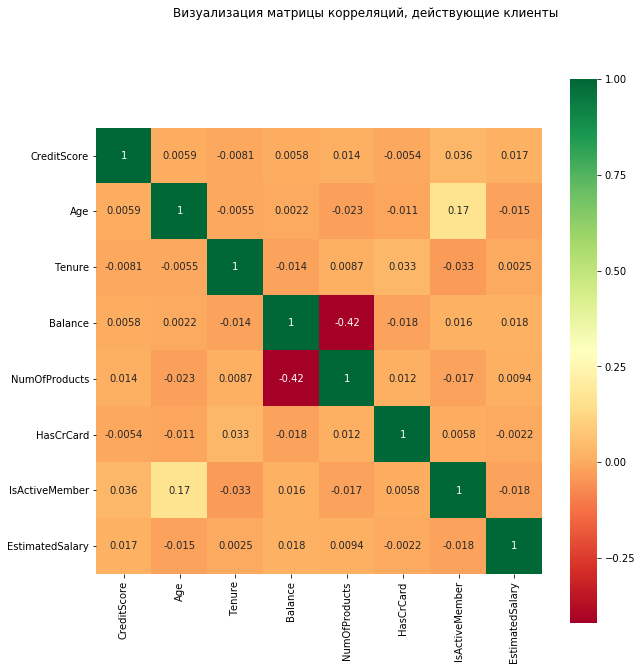

In [39]:
# карта интенсивности
plt.figure(figsize=(10,10))
sns.heatmap(not_exited_matrix.corr(), square=True, cmap='RdYlGn', annot=True)
plt.suptitle('Визуализация матрицы корреляций, действующие клиенты')
plt.show()

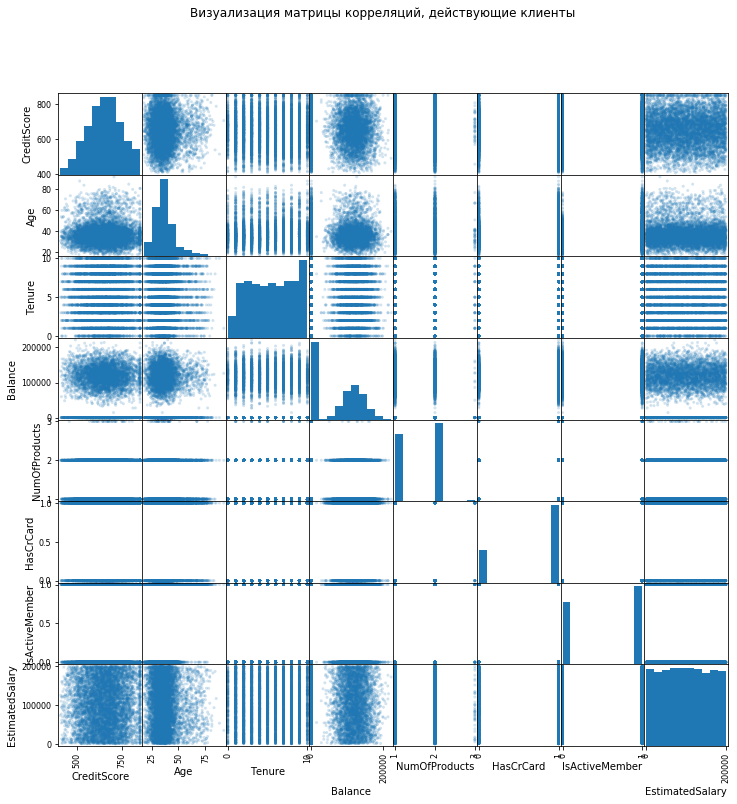

In [40]:
_ = pd.plotting.scatter_matrix(not_exited_matrix, figsize=[12, 12], alpha=0.2)
plt.suptitle('Визуализация матрицы корреляций, действующие клиенты')
plt.show()

Матрица корреляций показывает наличие некоторой **отрицательной** взаимосвязи (значение -0.41) между **количеством продуктов** (NumOfProducts) и **балансом** (Balance). 

Если посмотреть на сводную статистику (ниже), видно, что в **3/4 случаев** с **3 продуктами** значение баланса **равно 0**.  
Такая же проблема "перетягивания" есть и для **2 продуктов** - около **половины** случаев имеют **баланс 0**.

In [41]:
# вывод сводной статистики
# с учетом нулевых балансов
data_drop.query('Exited == 0').groupby('NumOfProducts')['Balance'].describe()

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,3334.0,101318.960795,50655.528989,0.0,83628.7825,112678.195,135152.62,221532.80
2,3862.0,48726.041406,62060.625508,0.0,0.0000,0.000,110642.51,214346.96
3,41.0,25778.433659,51784.559966,0.0,0.0000,0.000,0.00,161591.11


Если **убрать** нулевые значения, то значения сводной статистики **по всем случаям** (1, 2 и 3 продукта) достаточно похожи.

In [42]:
# вывод сводной статистики
# без учета нулевых балансов
data_drop.query('Exited == 0 and Balance > 0').groupby('NumOfProducts')['Balance'].describe()

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,2829.0,119405.236935,29391.054134,27288.43,99263.0900,119380.370,139480.180,221532.80
2,1568.0,120012.737187,30482.140271,14262.80,99298.6475,120429.505,140778.085,214346.96
3,9.0,117435.086667,36042.098870,49508.79,101713.8400,127122.790,141069.180,161591.11


Таким образом, была замечена тенденция, что чем **больше продуктов**, тем **больше** в выборке **строк с нулевым балансом**.  
Стоит отметить, что значений NumOfProducts для **3 продуктов** очень **мало** (и в принципе NumOfProducts - это дискретная величина с несколькими градациями). Однако следовало бы дополнительно изучить, почему при использовании **нескольких продуктов** так много **строк с нулевым балансом**.

Теперь посмотрим на **взаимосвязи** переменных для **ушедших** клиентов:

In [43]:
# ушедшие клиенты
# матрица с корреляциями
exited_matrix = data_drop.query('Exited == 1').drop(['Exited'], axis=1)
exited_matrix.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.000000,-0.011383,0.027492,0.005068,0.001924,0.000885,-0.002935,-0.038069
Age,-0.011383,1.000000,-0.021617,-0.019155,-0.009469,-0.023139,-0.015899,-0.001318
Tenure,0.027492,-0.021617,1.000000,0.027651,0.017881,0.003367,-0.044986,0.042370
Balance,0.005068,-0.019155,0.027651,1.000000,-0.005791,-0.019608,0.012119,-0.008366
NumOfProducts,0.001924,-0.009469,0.017881,-0.005791,1.000000,-0.009271,0.048418,0.029289
HasCrCard,0.000885,-0.023139,0.003367,-0.019608,-0.009271,1.000000,-0.072170,-0.020802
IsActiveMember,-0.002935,-0.015899,-0.044986,0.012119,0.048418,-0.072170,1.000000,-0.016183
EstimatedSalary,-0.038069,-0.001318,0.042370,-0.008366,0.029289,-0.020802,-0.016183,1.000000


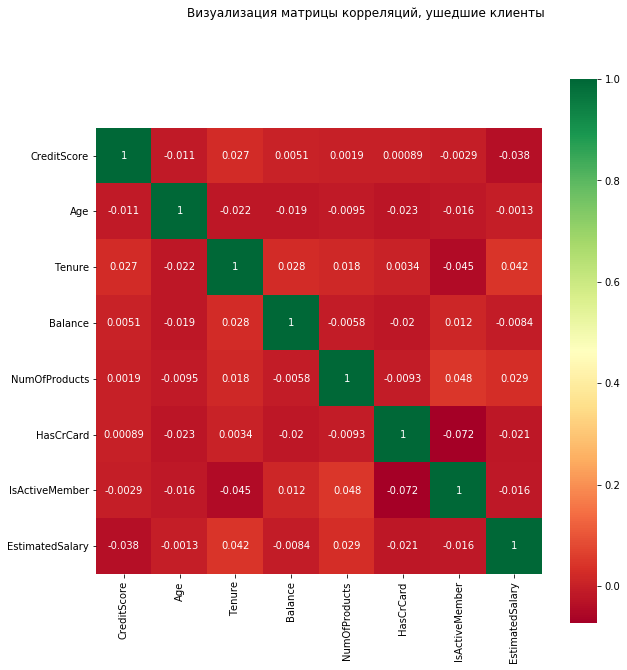

In [44]:
# карта интенсивности
plt.figure(figsize=(10,10))
sns.heatmap(exited_matrix.corr(), square=True, cmap='RdYlGn', annot=True)
plt.suptitle('Визуализация матрицы корреляций, ушедшие клиенты')
plt.show()

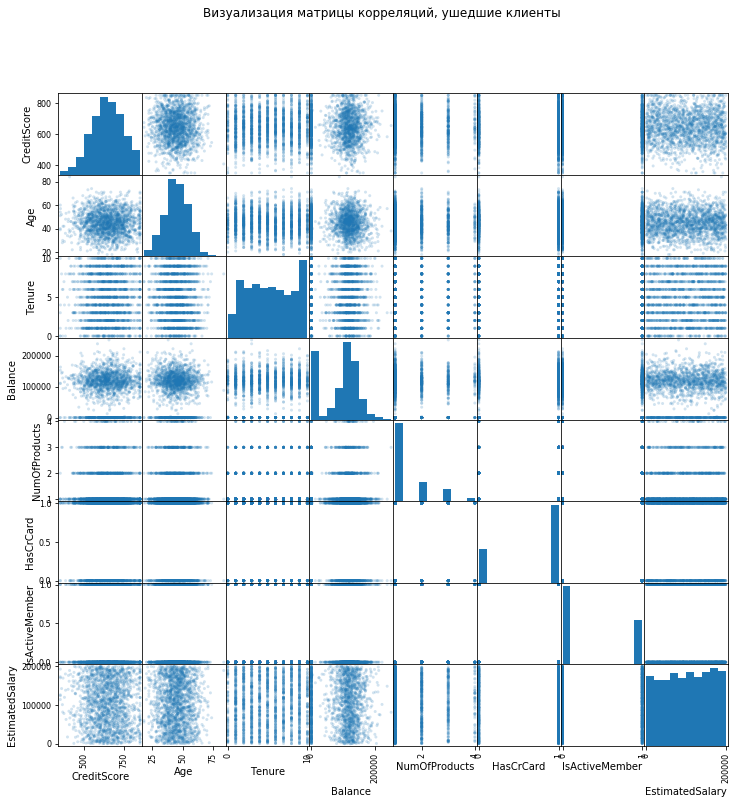

In [45]:
_ = pd.plotting.scatter_matrix(exited_matrix, figsize=[12, 12], alpha=0.2)
plt.suptitle('Визуализация матрицы корреляций, ушедшие клиенты')
plt.show()

Каких-то новых выдающихся закономерностей обнаружено **не было**. Если посмотреть на ранее найденную закономерность с NumOfProducts и Balance, то такой массовой проблемы с нулевыми балансами нет, хотя в случае с **3 продуктами** около **25% имеют 0 баланс**:

In [46]:
# вывод сводной статистики
# с учетом нулевых балансов
data.query('Exited == 1').groupby('NumOfProducts')['Balance'].describe()

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,1409.0,92028.819787,58077.936738,0.0,45472.280,110022.740,132217.4500,238387.56
2,348.0,90252.357155,58578.202498,0.0,26115.135,109006.295,129078.5725,210433.08
3,220.0,85853.087091,60120.714576,0.0,0.000,106655.515,131537.6400,250898.09
4,60.0,93733.135000,57507.383750,0.0,65787.320,116808.195,131589.5125,195238.29


Дополнительно построим матрицу корреляции <b> без учёта разбивки</b> клиентов на категории ушедшие-действующие.

In [47]:
# все клиенты
# матрица с корреляциями
all_matrix = data_drop.drop(['Exited'], axis=1)
all_matrix.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182
Age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520
Balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351
NumOfProducts,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990
HasCrCard,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136
IsActiveMember,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049
EstimatedSalary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000


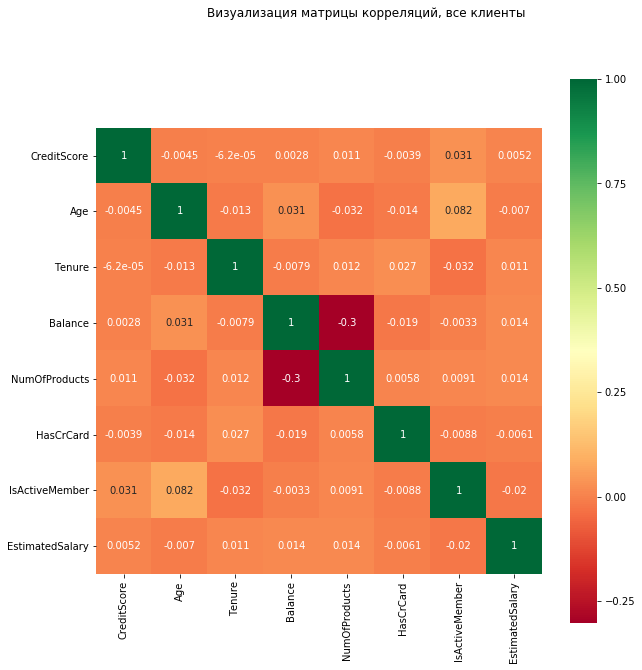

In [48]:
# карта интенсивности
plt.figure(figsize=(10,10))
sns.heatmap(all_matrix.corr(), square=True, cmap='RdYlGn', annot=True)
plt.suptitle('Визуализация матрицы корреляций, все клиенты')
plt.show()

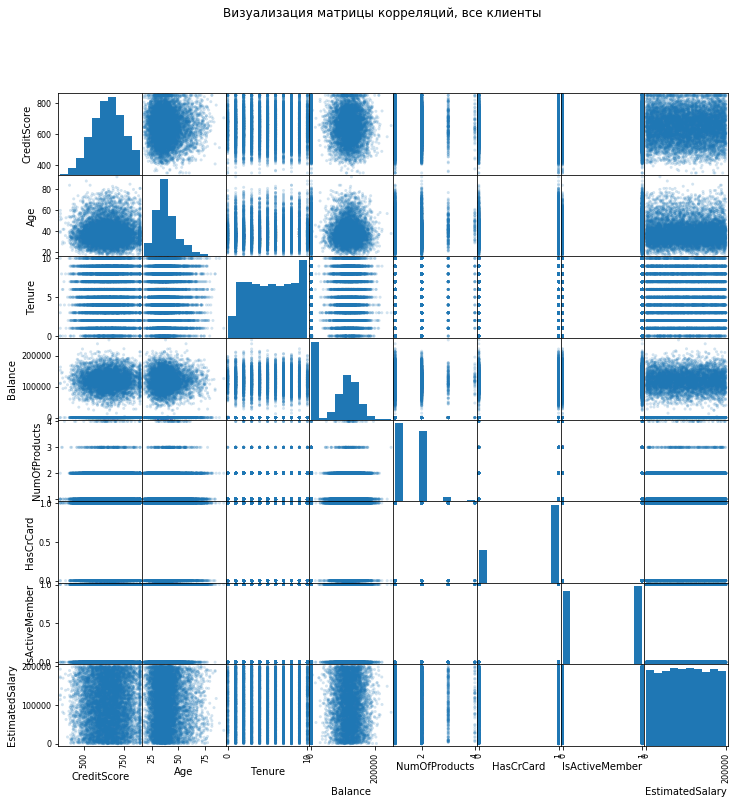

In [49]:
_ = pd.plotting.scatter_matrix(all_matrix, figsize=[12, 12], alpha=0.2)
plt.suptitle('Визуализация матрицы корреляций, все клиенты')
plt.show()

Новых выдающихся закономерностей не обнаружено. Заметен эффект отрицательной корреляции между количеством продуктов (NumOfProducts) и балансом (Balance). Но с этой закономерностью мы сталкивались при анализе <b>действующих</b> клиентов.

## 1.2. Вывод
- **Удалены** столбцы, которые не потребуются для обучения модели:
 - **RowNumber** — индекс строки в данных
 - **CustomerId** — уникальный идентификатор клиента
 - **Surname** - фамилия


- На следующих этапах необходимо **закодировать** столбцы:
 - **Geography** — страна проживания
 - **Gender** — пол


- Изучено **распределение количественных** переменных:
 - **CreditScore** — кредитный рейтинг. Нормальное и похожее распределение для ушедших и действующих клиентов.
 - **Age** — возраст. В обоих случаях распределение нормальное, однако есть основания полагать, что возраст ушедших и действующих клиентов **различается**.
 - **Balance** — баланс на счёте. **Больше трети** строк имеют **баланс ноль**. **14%** из них приходится на **ушедших** клиентов.  Без учета нулевых балансов, распределение для обоих случаев похоже и напоминает нормальное.
 - **EstimatedSalary** — предполагаемая зарплата. В распределении для обоих сучаев **нет** ярко выраженного пика. Приблизительно с **одинаковой частотой** можно встретить людей как с **высокой** зарплатой около **200 тысяч**, так и людей **со средней (100 тысяч)** и **низкой** зарплатой (близко расположенной **к нулю**).


- В колонке **Tenure** было принято решение **удалить пропуски (около 9% строк)**. 


- В колонке **NumOfProducts** более **90% значений** приходится либо на **1, либо на 2 продукта** банка. **Максимальное** количество продуктов в выборке **равно 4**, причем все случаи приходятся на клиентов **ушедших** из банка.


- Колонка **HasCrCard**. В выборке больше клиентов, у которых **есть кредитная карта** (около 70% клиентов). При этом доля ушедших среди тех, у кого есть и нет кредитной карты, довольно одинаковая - порядка 20%.


- Колонка  **IsActiveMember**. Доля так называемых активных и не активных клиентов практически **одинаковая**.
Однако доля ушедших среди активных клиентов почти **в 2 раза ниже**, чем среди неактивных.


- При исследовании **взаимосвязи** между переменными **не было** обнаружено значимых закономерностей.  
Для **действующих** клиентов было замечено, что чем **больше продуктов** используется клиентом, тем **чаще** в выборке встречаются клиенты с **нулевым балансом**. Особенно это заметно в случае с **3 продуктами**.

## 1.3. Подготовка данных для обучения

#### 1. Кодирование данных

Остановимся на более универсальной технике **One-Hot Encoding**, которая может работать в том числе с логистической регрессией.  
Как мы отметили выше, нам необходимо закодировать **два столбца: Geography и Gender**.

In [50]:
# использование One-Hot Encoding
data_drop_ohe = pd.get_dummies(data_drop, drop_first=True)
data_drop_ohe.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
5,645,44,8.0,113755.78,2,1,0,149756.71,1,0,1,1
6,822,50,7.0,0.00,2,1,1,10062.80,0,0,0,1
7,376,29,4.0,115046.74,4,1,0,119346.88,1,1,0,0
8,501,44,4.0,142051.07,2,0,1,74940.50,0,0,0,1
9,684,27,2.0,134603.88,1,1,1,71725.73,0,0,0,1


Проверили первые несколько строк - всё в порядке, были закодированы нужные столбцы.

#### 2. Выделение признаков и целевого признака. Формирование выборок

Выделим **признаки** и **целевой признак** из данных:

In [51]:
# выделение целевого признака
target = data_drop_ohe['Exited']
# выделение признаков
features = data_drop_ohe.drop('Exited', axis=1)

Теперь необходимо выделить **обучающую**, **валидационную** и **тестовую** выборки.
Возьмём стандартные пропорции: под **обучающую** выборку **60%** имеющихся данных, под **валидационную** и **тестовую** по **20%**.

Выделим сначала обучающую выборку (60%) и валидационную + тестовую (40%), а затем уже из второй выделим отдельно валидационную и отдельно тестовую (по 50%).

In [52]:
# обучающая и валидационная + тестовая выборка
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=54321)

# валидационная - valid, тестовая - test
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=54321)

print('Всего объектов в выборке:', len(data_drop_ohe))
print('Количество объектов в обучающей выборке:', len(features_train))
print('Количество объектов в валидационной выборке:', len(features_valid))
print('Количество объектов в тестовой выборке:', len(features_test))

Всего объектов в выборке: 9091
Количество объектов в обучающей выборке: 5454
Количество объектов в валидационной выборке: 1818
Количество объектов в тестовой выборке: 1819


#### 3. Масштабирование

Поскольку в данных встречаются признаки с разными шкалами (например, возраст и зарплата), то имеет смысл сделать **масштабирование признаков**.

In [53]:
# выделение признаком для масштабирования
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']

# создание образца модели и обучение
scaler = StandardScaler()
scaler.fit(features_train[numeric])

# масштабирование 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4414,0.625777,-1.139740,1.040677,0.593959,0.814528,1,0,0.820377,1,0,1
9949,2.057134,0.766672,1.387019,0.981733,-0.924194,1,0,-0.966028,0,0,0
3844,0.304240,-0.091213,0.347993,1.245642,-0.924194,1,0,0.022876,0,0,1
6827,0.688010,0.957313,1.733361,-1.224954,-0.924194,1,0,1.466357,0,0,0
3440,0.729499,0.766672,-1.037375,0.189547,-0.924194,1,1,-0.162237,0,0,0


## 1.3. Вывод

- Проведено **кодирование** данных в столбцах **Geography и Gender** с помощью техники **One-Hot Encoding**.
- Выделены **признаки** и **целевой признак (Exited)**.
- Выборка разделена на **обучающую**, **тестовую** и **валидационную**.
- Проведено **масштабирование** количественных признаков.

# Шаг 1. Вывод

Мы ознакомились с полученными данными и провели предобработку:
    
**1.1. Открытие файла**
 - В исходных данных содержалось **10000 строк** и **14 столбцов**.
 - **Целевой признак** - колонка **Exited** (клиент ушёл - 1, не ушёл - 0). В выборке ушедшими является 20% клиентов (дисбаланс классов).
 - В колонке **Tenure** (количество недвижимости у клиента) были **пропуски**.
 
    
**1.2. Проверка и изучение данных**
 - Изучено распределение и особенности данных по колонкам.
 - **Удалены** колонки, которые не потребуются для обучения модели (RowNumber, CustomerId, Surname).
 - **Удалены** строки с **пропусками** в колонке **Tenure**.

    
**1.3. Подготовка данных для обучения**
 - Проведено **кодирование** данных в столбцах Geography и Gender с помощью техники **One-Hot Encoding**.
 - Выделены **признаки** и **целевой признак (Exited)**.
 - Выборка разделена на **обучающую, тестовую** и **валидационную**.
 - Проведено **масштабирование** количественных признаков.

# 2. Исследование задачи

Ещё на этапе предобработки данных мы обратили внимание на **дисбаланс классов**: **ушедшими** является порядка **20% клиентов**.

In [54]:
print('Доля ушедших клиентов (обучающая выборка): {:.2%}'.format(target_train.sum() / target_train.count()))
print('Доля ушедших клиентов (валидационная выборка): {:.2%}'.format(target_valid.sum() / target_valid.count()))
print('Доля ушедших клиентов (тестовая выборка): {:.2%}'.format(target_train.sum() / target_train.count()))

Доля ушедших клиентов (обучающая выборка): 19.80%
Доля ушедших клиентов (валидационная выборка): 19.86%
Доля ушедших клиентов (тестовая выборка): 19.80%


На данном этапе обучим модель **без учёта дисбаланса** и посмотрим на результат.

##### 1. Логистическая регрессия (LogisticRegression)

Для примера используем модель **логистической регрессии**.  
Чтобы понять, как отработала модель, посмотрим на основные метрики: **accuracy**, **recall**, **precision**, **f1**.

In [55]:
# выбор модели
model = LogisticRegression(random_state=54321)

# обучение модели
model.fit(features_train, target_train)
    
# предсказания модели
predictions_train = model.predict(features_train)
predictions_valid = model.predict(features_valid)
    
# расчет accuracy
accuracy_train = accuracy_score(target_train, predictions_train)
accuracy_valid = accuracy_score(target_valid, predictions_valid)

# расчет recall
recall_train = recall_score(target_train, predictions_train)
recall_valid = recall_score(target_valid, predictions_valid)

# расчет precision
precision_train = precision_score(target_train, predictions_train)
precision_valid = precision_score(target_valid, predictions_valid)

# расчет f1
f1_train = f1_score(target_train, predictions_train)
f1_valid = f1_score(target_valid, predictions_valid)

print("Accuracy")
print("Обучающая выборка:", accuracy_train)
print("Валидационная выборка:", accuracy_valid)
print()
print("Recall")
print("Обучающая выборка:", recall_train)
print("Валидационная выборка:", recall_valid)
print()
print("Precision")
print("Обучающая выборка:", precision_train)
print("Валидационная выборка:", precision_valid)
print()
print("F1")
print("Обучающая выборка:", f1_train)
print("Валидационная выборка:", f1_valid)

Accuracy
Обучающая выборка: 0.8155482214888156
Валидационная выборка: 0.8168316831683168

Recall
Обучающая выборка: 0.2111111111111111
Валидационная выборка: 0.22437673130193905

Precision
Обучающая выборка: 0.5968586387434555
Валидационная выборка: 0.6044776119402985

F1
Обучающая выборка: 0.3119015047879617
Валидационная выборка: 0.32727272727272727


- **Accuracy**  
Самый высокий показатель у метрики **accuracy** - **около 80%**. Но, как мы знаем, в выборке **около 80%** - это **действующие** клиенты. Поэтому если мы укажем **константу 0**, то вероятность угадать правильный ответ также будет **80%**.


- **Recall**  
Результат на уровне **0.22**. Значит, модель не очень хорошо находит **положительные** ответы (т. е. клиентов, ушедших из банка). Условно говоря, из 100 ушедших верно определяется только 22 клиента.


- **Precision**  
Результат на уровне **0.6**. Значит, из 100 определенных моделью клиентов как "ушедших", реально ушедшими являются 60 клиентов.


- **F1**  
F1-мера объединяет данные полноты и точности. В нашем случае показатель **F1** около **0.32** - это меньше того, что требуется в задании (метрика должна быть не ниже 0.59).

##### 2. Случайный лес (RandomForest)

Рассмотрим ещё одну модель без учёта дисбаланса классов - **случайный лес**.  
Рассмотрим только те случаи, где **F1-мера больше 0.55**.

In [56]:
# цикл для n_estimators
for i in range(50, 151, 10):
    
    # выбор модели с указанием n_estimators
    model = RandomForestClassifier(random_state=54321, n_estimators=i, max_depth=10)
    # обучение модели
    model.fit(features_train, target_train)
    
    # предсказания модели
    predictions_train = model.predict(features_train)
    predictions_valid = model.predict(features_valid)
    
    # расчет f1
    f1_train = f1_score(target_train, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)
    
    if f1_valid > 0.55:
        print('n_estimators:', i)
        print("F1")
        print("Обучающая выборка:", f1_train)
        print("Валидационная выборка:", f1_valid)
        print()

n_estimators: 50
F1
Обучающая выборка: 0.7392290249433108
Валидационная выборка: 0.5734265734265733

n_estimators: 60
F1
Обучающая выборка: 0.7354618015963511
Валидационная выборка: 0.5809859154929577

n_estimators: 70
F1
Обучающая выборка: 0.7346241457858771
Валидационная выборка: 0.5814360770577934

n_estimators: 80
F1
Обучающая выборка: 0.7379192723138147
Валидационная выборка: 0.5818815331010453

n_estimators: 90
F1
Обучающая выборка: 0.7376209447922596
Валидационная выборка: 0.5874125874125874

n_estimators: 100
F1
Обучающая выборка: 0.7360637087599545
Валидационная выборка: 0.5884413309982487

n_estimators: 110
F1
Обучающая выборка: 0.7383390216154722
Валидационная выборка: 0.5894736842105263

n_estimators: 120
F1
Обучающая выборка: 0.7372013651877134
Валидационная выборка: 0.5863874345549739

n_estimators: 130
F1
Обучающая выборка: 0.7414965986394558
Валидационная выборка: 0.5863874345549739

n_estimators: 140
F1
Обучающая выборка: 0.7412031782065833
Валидационная выборка: 0.582

Для **случайного леса** более характерна проблема **переобучения** модели. Метрика F1 в **обучающей** выборке может достигать значений **более 0.7**.  

Тем не менее, модель показала **более хорошие** результаты, чем логистическая регрессия. Даже без учёта дисбаланса, в некоторых случаях **F1-мера** достигает значения **0.58**. Значит, есть шанс, что после **учёта дисбаланса** качество модели вырсатет и достигнет требуемых 0.59.

Среди <b>случайного леса</b> с разными n_estimators наиболее высокие показатели были при значениях:
<br />
- n_estimators=110, F1 - 0.5895
<br />
- n_estimators=100, F1 - 0.5884
<br />
- n_estimators=90, F1 - 0.5874

### Расчет метрики AUC-ROC

Рассчитаем метрики AUC-ROC и построим графики для невзвешенных моделей. В качестве <b>"представителя" от случайного леса</b> выберем модель с наилучшими результатами по валидационной выборке: <b>n_estimators=110</b>.

Значение метрики AUC-ROC (логистическая регрессия): 0.7537782070318664
Значение метрики F1 (логистическая регрессия): 0.32727272727272727

Значение метрики AUC-ROC (случайный лес): 0.8460236854463218
Значение метрики F1 (случайный лес): 0.5894736842105263


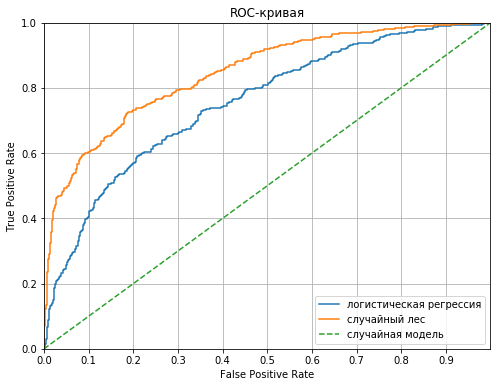

In [57]:
# логистическая регрессия
model = LogisticRegression(random_state=54321)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid) # предсказания

probabilities_valid = model.predict_proba(features_valid) # вычисление вероятностей
probabilities_one_valid = probabilities_valid[:, 1] # вероятность того, что значение близко к 1
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(target_valid, probabilities_one_valid) # значения TPR, FPR, порогов

auc_roc_logreg = roc_auc_score(target_valid, probabilities_one_valid) # значение AUC-ROC
print('Значение метрики AUC-ROC (логистическая регрессия):', auc_roc_logreg)
print('Значение метрики F1 (логистическая регрессия):', f1_score(target_valid, predictions_valid))
print()

# случайный лес
model = RandomForestClassifier(random_state=54321, n_estimators=110, max_depth=10)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid) # предсказания

probabilities_valid = model.predict_proba(features_valid) # вычисление вероятностей
probabilities_one_valid = probabilities_valid[:, 1] # вероятность того, что значение близко к 1
fpr_randfor, tpr_randfor, thresholds_randfor = roc_curve(target_valid, probabilities_one_valid) # значения TPR, FPR, порогов

auc_roc_randfor = roc_auc_score(target_valid, probabilities_one_valid) # значение AUC-ROC
print('Значение метрики AUC-ROC (случайный лес):', auc_roc_randfor)
print('Значение метрики F1 (случайный лес):', f1_score(target_valid, predictions_valid))

# построение графика TPR, FPR
plt.figure(figsize=(8,6))
plt.plot(fpr_logreg, tpr_logreg, label='логистическая регрессия')
plt.plot(fpr_randfor, tpr_randfor, label='случайный лес')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='случайная модель')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks([i*0.1 for i in range(10)])

plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.grid()
plt.show()

Более высокий показатель <b>AUC-ROC</b> у модели <b>случайного леса - 0.84</b> против <b>логистической регрессии - 0.75</b>. При одинаковом уровне ложноположительных ответов (FPR) случайный лес лучше определяет долю истинно положительных ответов.

# Шаг 2. Вывод

- В выборке наблюдается **дисбаланс классов**: **ушедшими** является около **20% клиентов**.

    
- Проведено обучение **логистической регрессии** без учёта дисбаланса.
 - Самое больше значение у метрики **accuracy** - **0.8**. Но при проверке модели константой (значение 0 для всех клиентов) мы также получили бы значение **0.8**.
 - Значение метрики **F1** (среднее гармоническое полноты и точности) довольно низкое - **0.32**.
    

- Проведено обучение **случайного леса** без учёта дисбаланса.
 - Для модели существует проблема **переобучения**. Однако на валидационной выборке она всё равно показала **более высокие** результаты, чем логистическая регрессия: в некоторых случаях F1 достигал значения **0.58**.

    
- Для обоих моделей рассчитана метрика <b>AUC-ROC</b>: более высокий показатель продемонстрировала модель <b>случайного леса - 0.84</b> против <b>логистической регрессии - 0.75</b>.

# 3. Борьба с дисбалансом

Для борьбы с дисбалансом есть разные методы, например: **взвешивание классов, upsampling** и **downsampling**.  
Посмотрим, какие результаты будут при использовании **взвешивания классов**.  

### 3.1. Взвешивание классов

##### 1. Случайный лес (RandomForestClassifier)
Сначала изучим изменения результатов для **случайного леса**. В качестве фильтра поставим значение F1 **0.59 и больше**:

In [58]:
# цикл для n_estimators
for i in range(50, 151, 10):
    
    # выбор модели с указанием n_estimators
    model = RandomForestClassifier(random_state=54321, n_estimators=i, max_depth=10, class_weight='balanced')
    # обучение модели
    model.fit(features_train, target_train)
    
    # предсказания модели
    predictions_train = model.predict(features_train)
    predictions_valid = model.predict(features_valid)
    
    # расчет f1
    f1_train = f1_score(target_train, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)
    
    if f1_valid > 0.59:
        print('n_estimators:', i)
        print("F1")
        print("Обучающая выборка:", f1_train)
        print("Валидационная выборка:", f1_valid)
        print()

n_estimators: 60
F1
Обучающая выборка: 0.8263950398582817
Валидационная выборка: 0.5954415954415955

n_estimators: 70
F1
Обучающая выборка: 0.8251996450754214
Валидационная выборка: 0.594900849858357

n_estimators: 80
F1
Обучающая выборка: 0.8316303864948911
Валидационная выборка: 0.5985815602836879

n_estimators: 100
F1
Обучающая выборка: 0.8271879164815639
Валидационная выборка: 0.5952045133991537

n_estimators: 110
F1
Обучающая выборка: 0.8291814946619216
Валидационная выборка: 0.5935302390998594

n_estimators: 120
F1
Обучающая выборка: 0.8306595365418895
Валидационная выборка: 0.5977337110481586

n_estimators: 130
F1
Обучающая выборка: 0.8342293906810037
Валидационная выборка: 0.5954415954415955

n_estimators: 140
F1
Обучающая выборка: 0.8309481216457961
Валидационная выборка: 0.5954415954415955

n_estimators: 150
F1
Обучающая выборка: 0.8339285714285714
Валидационная выборка: 0.5991440798858774



Да, мы смогли получить значение **F1** на уровне **0.59**. Тем не менее, обратной стороной, как мы уже отметили, является явное **переобучение** модели.

После <b>взвешивания классов</b> для <b>случайного леса</b> с разными n_estimators наиболее высокие показатели получились при значениях:
- n_estimators=150, F1 - 0.5991
- n_estimators=80, F1 - 0.5985   
- n_estimators=120, F1 - 0.5977

##### 2. Логистическая регрессия
Теперь посмотрим, как изменятся результаты для **логистической регрессии**:

In [59]:
# результат ДО взвешивания классов
model = LogisticRegression(random_state=54321)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1 (до взвешивания классов):", f1_score(target_valid, predicted_valid))

# результат ПОСЛЕ взвешивания классов
model = LogisticRegression(random_state=54321, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1 (после взвешивания классов):", f1_score(target_valid, predicted_valid))

F1 (до взвешивания классов): 0.32727272727272727
F1 (после взвешивания классов): 0.4778761061946903


**F1-мера** стала несколько выше, чем до взвешивания. Но все равно результат ещё недостаточно высокий.  

### 3.2. Upsampling

Посмотрим, как на результаты повлияет другая техника - **upsampling**, суть которой в том, чтобы сделать более редкие классы **не редкими**. То есть чтобы 0 и 1 встречались в выборке приблизительно одинаково.

Сначала напишем функцию для **upsample**:

In [60]:
# функция для upsample
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0] # признаки с таргет 0
    features_ones = features[target == 1] # признаки с таргет 1
    target_zeros = target[target == 0] # целевой признак 0
    target_ones = target[target == 1] # целевой признак 1

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) # увеличиваем признаки с 1
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) # увеличиваем таргеты с 1
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321) # перемешиваем данные
    
    return features_upsampled, target_upsampled

##### 1. Случайный лес (RandomForestClassifier)

Теперь возьмём данные с **увеличенным** количеством ответов **1** и выведем **значения F1** в модели **случайного леса**:

In [61]:
# увеличим количество положительных ответов в 4 раза (т. к. в исходной выборке они встречаются в 4 раза реже)
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

# цикл для n_estimators
for i in range(50, 151, 10):
    
    # выбор модели с указанием n_estimators
    model = RandomForestClassifier(random_state=54321, n_estimators=i, max_depth=10)
    # обучение модели
    model.fit(features_upsampled, target_upsampled)
    
    # предсказания модели
    predictions_upsampled = model.predict(features_upsampled)
    predictions_valid = model.predict(features_valid)
    
    # расчет f1
    f1_upsampled = f1_score(target_upsampled, predictions_upsampled)
    f1_valid = f1_score(target_valid, predictions_valid)
    
    if f1_valid > 0.59:
        print('n_estimators:', i)
        print("F1")
        print("Обучающая выборка:", f1_upsampled)
        print("Валидационная выборка:", f1_valid)
        print()

n_estimators: 70
F1
Обучающая выборка: 0.9238578680203046
Валидационная выборка: 0.5958549222797926

n_estimators: 80
F1
Обучающая выборка: 0.9268685938039848
Валидационная выборка: 0.5943152454780362

n_estimators: 90
F1
Обучающая выборка: 0.9265197831353097
Валидационная выборка: 0.5966277561608301

n_estimators: 100
F1
Обучающая выборка: 0.9260242354298903
Валидационная выборка: 0.6002587322121604

n_estimators: 110
F1
Обучающая выборка: 0.9277233429394812
Валидационная выборка: 0.5955786736020806

n_estimators: 120
F1
Обучающая выборка: 0.9272957714022353
Валидационная выборка: 0.5953002610966057

n_estimators: 130
F1
Обучающая выборка: 0.926480755934547
Валидационная выборка: 0.5911458333333333



Такой метод также продемонстрировал **хорошие результаты**.  
В случае со **100 деревьями** было получено значение F1 **0.6** для валидационной выборки.

##### 2. Логистическая регрессия¶

In [62]:
# результат ДО взвешивания классов
model = LogisticRegression(random_state=54321)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1 (до взвешивания классов):", f1_score(target_valid, predicted_valid))

# результат ПОСЛЕ взвешивания классов
model = LogisticRegression(random_state=54321, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1 (после взвешивания классов):", f1_score(target_valid, predicted_valid))

# результат ПОСЛЕ upsampling
features_upsampled, target_upsampled = upsample(features_train, target_train, 4) # upsampling
model = LogisticRegression(random_state=54321, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1 (после upsampling):", f1_score(target_valid, predicted_valid))

F1 (до взвешивания классов): 0.32727272727272727
F1 (после взвешивания классов): 0.4778761061946903
F1 (после upsampling): 0.4797630799605134


Видим, что результаты по **взвешиванию** и **upsampling** довольно похожи. Они лучше, чем без применения какой-либо техники, но всё равно не дотягивают до 0.59.

### 3.3. Изменение порога, метрики AUC-ROC

Изучим значение ещё одной важной метрики - **AUC-ROC**.  

На работу модели влияет **порог** - граница, которая определяет, как нужно классифицировать значение, т. е. присвоить в итоге 0 или 1.  
С помощью **регулирования порога** можно влиять на результаты: например, при очень **низком** пороге у модели будут **высокие** показатели **полноты** (т. е. все ушедшие клиенты будут выявлены моделью). Но при этом будет **высокий** уровень **False Positive** ответов (т. е. клиент на самом деле не ушел, но при этом модель определила его как ушедшего).

**ROC-кривая** показывает, как при **разных порогах** изменяются показатели TPR (истинно положительных) и FPR (ложноположительных) ответов.  
При этом можно сравнить, насколько модель **отличается от случайной**, посчитав площадь под кривой **AUC-ROC**.

Посмотрим, как выглядят **ROC-кривые** для **логистической регрессии** и **случайного леса** и выведем значение метрики **AUC-ROC**.

Значение метрики AUC-ROC (логистическая регрессия): 0.7591624728837953
Значение метрики AUC-ROC (случайный лес): 0.8433315525203574


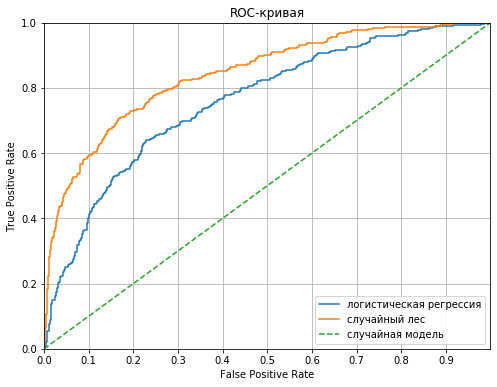

In [63]:
# логистическая регрессия
model = LogisticRegression(random_state=54321, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid) # вычисление вероятностей
probabilities_one_valid = probabilities_valid[:, 1] # вероятность того, что значение близко к 1
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(target_valid, probabilities_one_valid) # значения TPR, FPR, порогов

auc_roc_logreg = roc_auc_score(target_valid, probabilities_one_valid) # значение AUC-ROC
print('Значение метрики AUC-ROC (логистическая регрессия):', auc_roc_logreg)

# случайный лес
model = RandomForestClassifier(random_state=54321, n_estimators=150, max_depth=10, class_weight='balanced')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid) # вычисление вероятностей
probabilities_one_valid = probabilities_valid[:, 1] # вероятность того, что значение близко к 1
fpr_randfor, tpr_randfor, thresholds_randfor = roc_curve(target_valid, probabilities_one_valid) # значения TPR, FPR, порогов

auc_roc_randfor = roc_auc_score(target_valid, probabilities_one_valid) # значение AUC-ROC
print('Значение метрики AUC-ROC (случайный лес):', auc_roc_randfor)

# построение графика TPR, FPR
plt.figure(figsize=(8,6))
plt.plot(fpr_logreg, tpr_logreg, label='логистическая регрессия')
plt.plot(fpr_randfor, tpr_randfor, label='случайный лес')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='случайная модель')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks([i*0.1 for i in range(10)])

plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.grid()
plt.show()

Более высокий показатель **AUC-ROC** у модели **случайного леса**. При **одинаковом** уровне **ложноположительных ответов** (FPR) **случайный лес** **лучше** определяет долю **истинно положительных ответов**.

Таким образом, мы рассмотрели **несколько моделей**: **логистическую регрессию** и несколько вариантов **случайного леса**.  
Дополнительно мы применили **техники борьбы с дисбалансом**: **взвешивание классов** и **upsampling**.

По метрикам **F1** и **AUC-ROC** более хорошие результаты продемонстрировал **случайный лес**. Мы остановимся на модели **случайного леса (150 деревьев)** со **взвешенными классами**. Используем данную модель для **финального тестирования**.

Выведем для данной модели **матрицу ошибок** и **отчет по классификации**:

In [64]:
# случайный лес
model = RandomForestClassifier(random_state=54321, n_estimators=150, max_depth=10, class_weight='balanced')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

# матрица ошибок и отчет по классификации
print(confusion_matrix(target_valid, predictions_valid))
print(classification_report(target_valid, predictions_valid))

[[1327  130]
 [ 151  210]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1457
           1       0.62      0.58      0.60       361

    accuracy                           0.85      1818
   macro avg       0.76      0.75      0.75      1818
weighted avg       0.84      0.85      0.84      1818



# Шаг 3. Вывод

Было рассмотрено несколько техник для **борьбы с дисбалансом**:
- **Взвешивание классов**
  - Модель **случайного леса** показала хорошие результаты **F1** на валидационной выборке - значение достигло требуемого уровня **0.59**.
  - Метрика **F1** для **логистической регрессии** стала **выше - 0.47**, однако не достигла требуемого значения 0.59.
    

- **Upsampling** (увеличение количества редких элементов)
 - **Случайный лес** также продемонстрировал довольно высокие результаты **F1-меры** - **0.59 и выше**.
 - Для **логистической регрессии** показатель **F1** также был равен **0.47**.
    

- **Метрика AUC-ROC**
 - Для моделей **случайного леса** и **логистической регрессии** дополнительно рассчитана метрика **AUC-ROC**.
 - Значение **AUC-ROC** для **случайного леса - 0.84**, для **логистической регрессии - 0.76**.
    
Поскольку более высокие показатели продемонстрировал **случайный лес**, мы приняли решение остановиться на этой модели: количество деревьев 150, глубина 10, взвешенные классы.

Ниже пример обобщающей таблицы по разным моделям с учётом и без учёта балансировки классов.

In [65]:
final_table = pd.DataFrame({
    'model_name': ['logistic_regression', 'random_forest', 'logistic_regression', 'random_forest'],
    'n_estimators': [np.nan, 110, np.nan, 150],
    'weighted_classes': [False, False, True, True],
    'f1_score': [0.3272, 0.5895, 0.4778, 0.5991],
    'auc_roc_score':[0.7537, 0.8460, 0.7591, 0.8433]
    
})

final_table

,model_name,n_estimators,weighted_classes,f1_score,auc_roc_score
0,logistic_regression,NaN,False,0.3272,0.7537
1,random_forest,110.0,False,0.5895,0.8460
2,logistic_regression,NaN,True,0.4778,0.7591
3,random_forest,150.0,True,0.5991,0.8433


# 4. Тестирование модели

Посмотрим на результаты **случайного леса** для **тестовой выборки**: 

In [66]:
# случайный лес
model = RandomForestClassifier(random_state=54321, n_estimators=150, max_depth=10, class_weight='balanced')
model.fit(features_train, target_train)

# предсказания модели
predictions_test = model.predict(features_test)

# расчет f1
f1_test = f1_score(target_test, predictions_test)
print('Знаение F1:', f1_test)
print()

# матрица ошибок и отчет по классификации
print(confusion_matrix(target_test, predictions_test))
print(classification_report(target_test, predictions_test))

Знаение F1: 0.597168597168597

[[1274  132]
 [ 181  232]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1406
           1       0.64      0.56      0.60       413

    accuracy                           0.83      1819
   macro avg       0.76      0.73      0.74      1819
weighted avg       0.82      0.83      0.82      1819



Значение метрики AUC-ROC (случайный лес): 0.8433383045336659


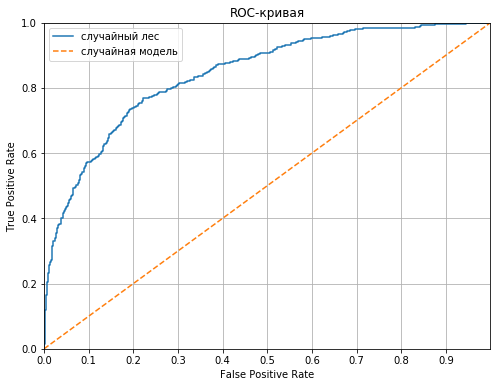

In [67]:
# случайный лес
model = RandomForestClassifier(random_state=54321, n_estimators=150, max_depth=10, class_weight='balanced')
model.fit(features_train, target_train)

probabilities_test = model.predict_proba(features_test) # вычисление вероятностей
probabilities_one_test = probabilities_test[:, 1] # вероятность того, что значение близко к 1
fpr_randfor, tpr_randfor, thresholds_randfor = roc_curve(target_test, probabilities_one_test) # значения TPR, FPR, порогов

auc_roc_randfor = roc_auc_score(target_test, probabilities_one_test) # значение AUC-ROC
print('Значение метрики AUC-ROC (случайный лес):', auc_roc_randfor)

# построение графика TPR, FPR
plt.figure(figsize=(8,6))
plt.plot(fpr_randfor, tpr_randfor, label='случайный лес')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='случайная модель')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks([i*0.1 for i in range(10)])

plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.grid()
plt.show()

Нам удалось довести значение **метрики F1** до уровня **0.59** - модель прошла испытание **тестовой** выборкой.  
Дополнительно мы построили **ROC-кривую** и вычислили **AUC-ROC - 0.84** - модель также продемонстрировала хорошие результаты.

# Шаг 4. Вывод

- В качестве финальной модели был выбран **случайный лес**: 150 деревьев, максимальная глубина 10, взвешенные классы.
- Модель выдержала испытание **тестовой выборкой** - значение **F1** не упало ниже 0.59.
- Значение **AUC-ROC - 0.84** осталось на том же уровне.

# Итоговый вывод
    
- **Шаг 1**. Мы ознакомились с полученными данными и провели предобработку:
 - **1.1. Открытие файла**. Изучены исходные данные и общая информация по файлу. Отмечен **дисбаланс классов** в выборке и наличие **пропусков** в колонке Tenure (количество недвижимости у клиента).
 - **1.2. Проверка и изучение данных**. **Удалены** колонки, которые не потребовались для обучения модели**. Также **удалены** строки с **пропусками** в колонке Tenure. Изучено распределение и особенности данных по колонкам.
 - **1.3. Подготовка данных для обучения**. Проведено **кодирование** данных в столбцах **Geography и Gender** с помощью техники **One-Hot Encoding**. Выделены **признаки** и **целевой признак (Exited)**. Выборка разделена на **обучающую, тестовую** и **валидационную**. Проведено **масштабирование** количественных признаков.   
    
 
- **Шаг 2**. Рассмотрено несколько моделей **без учёта дисбаланса** классов:
 - **Логистическая регрессия**. Значение метрики F1 - **0.32**.
 - **Случайный лес**. Значение метрики F1 - на уровне **0.58**.
    
    
    
- **Шаг 3**. Было рассмотрено несколько техник для борьбы с дисбалансом:
 - **Взвешивание классов**. F1 случайного леса - около 0.59. F1 логистической регрессии - 0.47. 
 - **Upsampling**. F1 случайного леса - около 0.59 (в некоторых случаях 0.6). F1 логистической регрессии - 0.47. 
 - Дополнительно рассмотрена **метрика AUC-ROC**. Значение AUC-ROC для случайного леса - 0.84, для логистической регрессии - 0.76.
    
    
- **Шаг 4**. Тестирование финальной модели:
 - В качестве финальной модели был выбран **случайный лес**: 150 деревьев, максимальная глубина 10, взвешенные классы.
 - Модель выдержала испытание тестовой выборкой - значение **F1 не упало ниже 0.59**.
 - Значение **AUC-ROC - 0.84** осталось на том же уровне.